# UDACITY MACHINE LEARNING ENGINEER NANODEGREE

## CAPSTONE PROJECT - NFL BIG DATA BOWL (KAGGLE)

This is the main notebook that will be used in this Udacity Capstone Project. This project is based on the Kaggle competition 'NFL Big Data Bowl', which is briefly described below [1]:

“American football is a complex sport. From the 22 players on the field to specific characteristics that ebb and flow throughout the game, it can be challenging to quantify the value of specific plays and actions within a play. Fundamentally, the goal of football is for the offense to run (rush) or throw (pass) the ball to gain yards, moving towards, then across, the opposing team’s side of the field in order to score. And the goal of the defense is to prevent the offensive team from scoring.
…
In this competition, you will develop a model to predict how many yards a team will gain on given rushing plays as they happen.”

In particular, this notebook contains the following sections:

1. Exploring the data: Summary of the data, size of the input dataset, available features & initial visualization
2. Cleaning the data: Imputation of missing values, removal of rows/columns with incomplete records
3. Feature engineering: Feature scaling and encoding of categorical variables
4. Feature selection: Selection of the most significant features & correlation analysis
5. Creating the model: XGBoost model will be built using AWS SageMaker high-level API
6. Evaluating the model: Use the RMSE metric to evaluate model performance against the benchmark model

Please note that this Jupyter Notebook is run inside an Amazon Sagemaker instance.

References:

[1] https://www.kaggle.com/c/nfl-big-data-bowl-2020/overview (2019)

## 1. Exploring the data

This section includes an initial overview of the data. A more detailed analysis of specific features and their relationships to the response variable (yards gained/lost on a given play) was conducted in the Exploratory software and can be found in the accompanying HTML file. Please note that in order for the analysis to be done in Exploratory the dataset's size had to be reduced. This was done in a Jupyter Notebook, and the code used to do so can be found below:

    import pandas as pd

    df = pd.read_csv('train.csv', low_memory = False)

    new_df = df[['Team', 'DisplayName', 'JerseyNumber', 'YardLine', 'Distance',
           'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
           'OffenseFormation', 'OffensePersonnel',
           'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection',
           'Yards', 'PlayerHeight', 'PlayerWeight', 
           'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
           'Week', 'Stadium', 'StadiumType', 'Turf', 'GameWeather',
           'Temperature', 'Humidity', 'WindSpeed', 'WindDirection']]

'df' represents a dataframe of the original 'train.csv' file, and 'new_df' the reduced dataframe used in the Exploratory analysis.

The columns displayed above will be dealt with in more detail in the Exploratory analysis.

In [1]:
import io
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

# Importing the helper file in which helper functions are defined
import helpers

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [2]:
# sagemaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
# Uploading the local file to S3
sagemaker_session.upload_data(path='main.csv', bucket=bucket, key_prefix='input') 

's3://sagemaker-us-east-2-961021140576/input/main.csv'

In [4]:
# reading the data into a dataframe
nfl_df = pd.read_csv('main.csv', low_memory = False)

In [178]:
# initial checks on the data
nfl_df.describe()

# columns
all_columns = nfl_df.columns
print(all_columns)
print('\n')

# dataframe shape
print(nfl_df.shape)

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')


(509762, 49)


From the above cell we can see there are roughly 510000 rows and 49 columns in the dataframe.

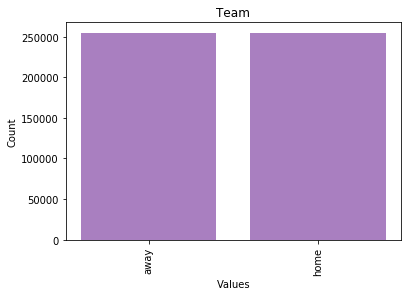

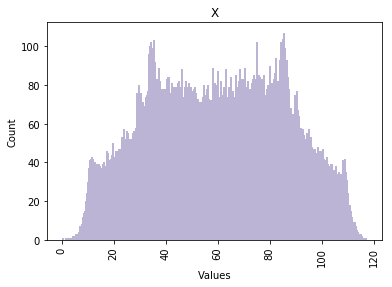

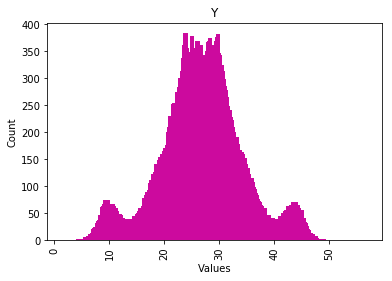

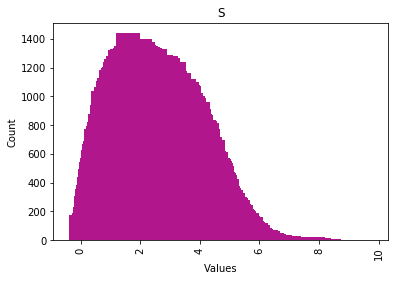

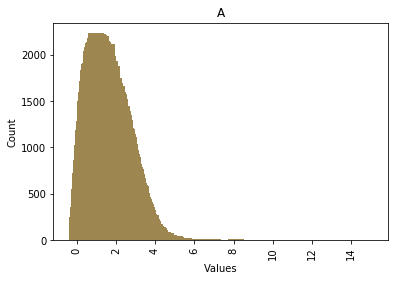

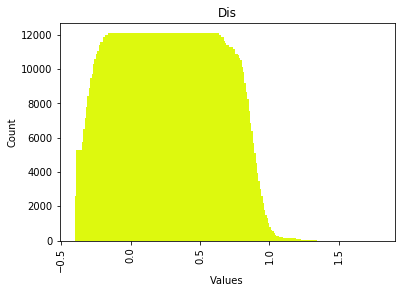

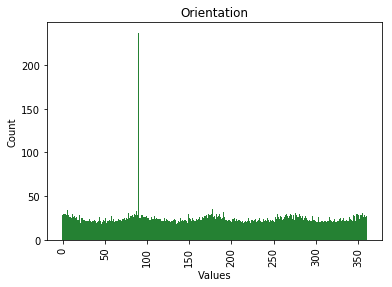

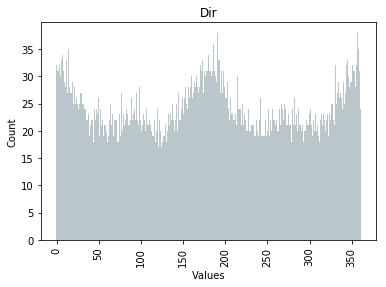

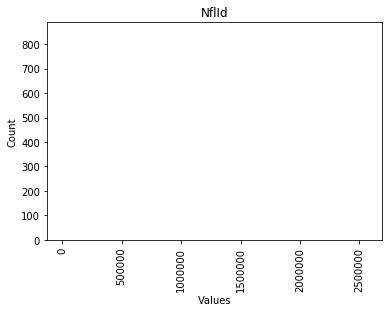

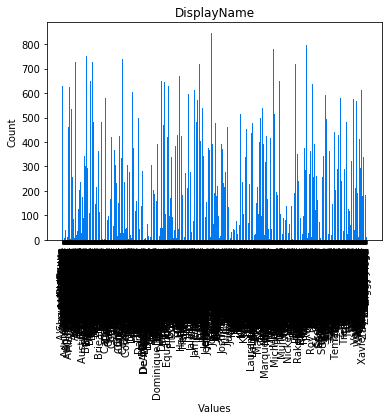

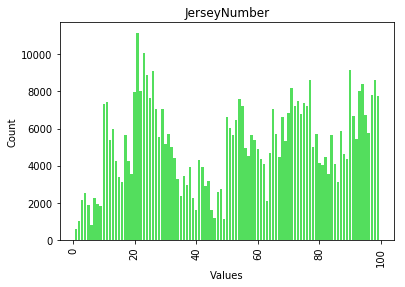

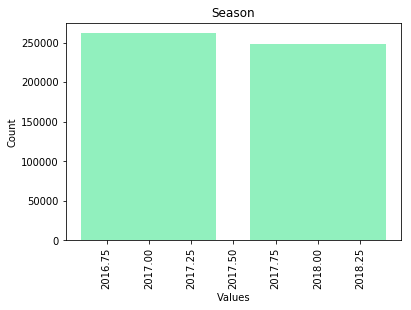

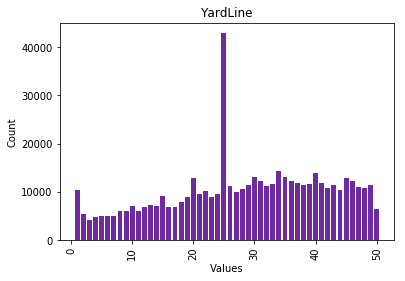

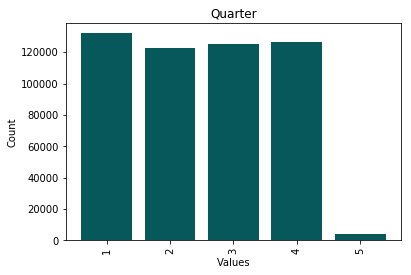

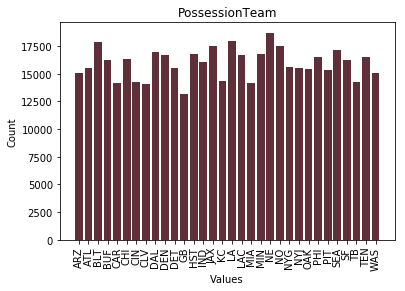

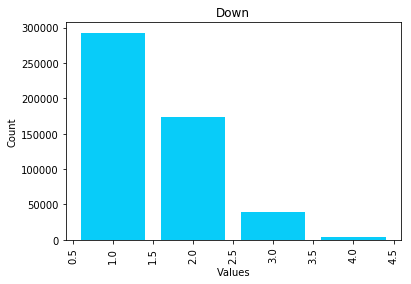

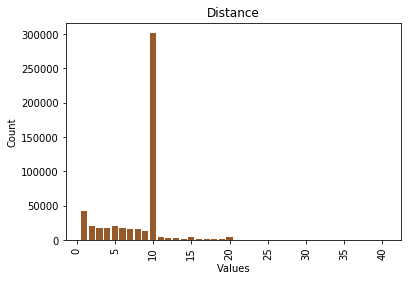

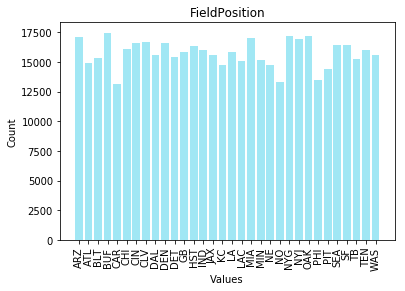

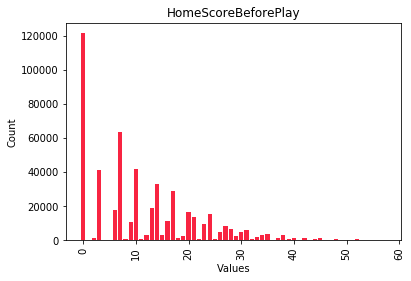

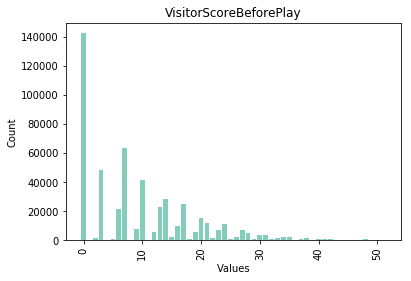

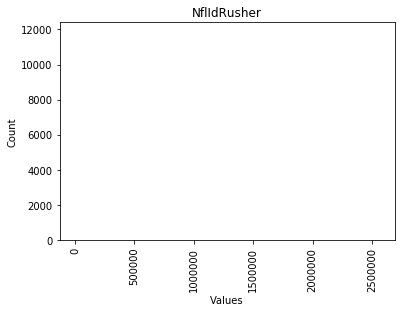

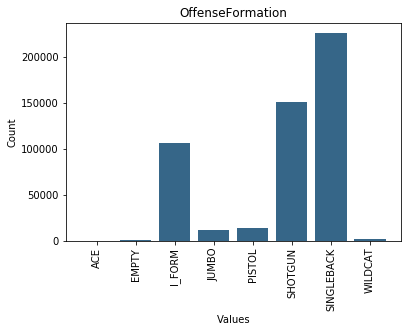

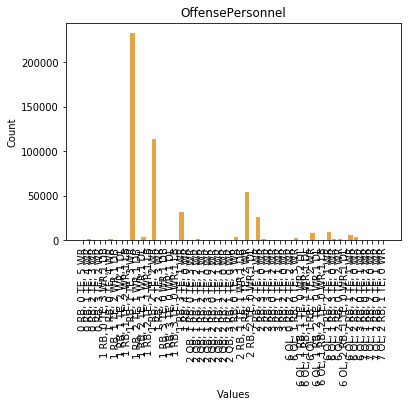

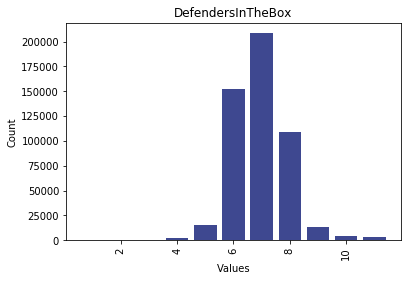

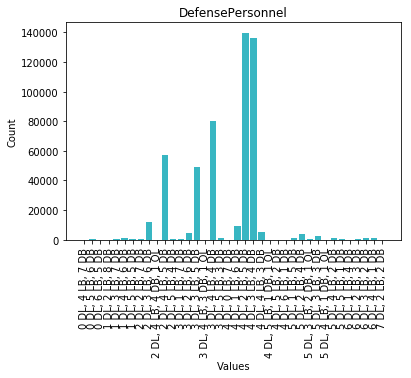

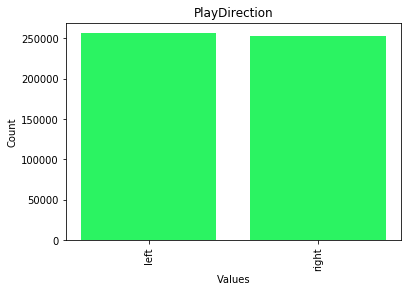

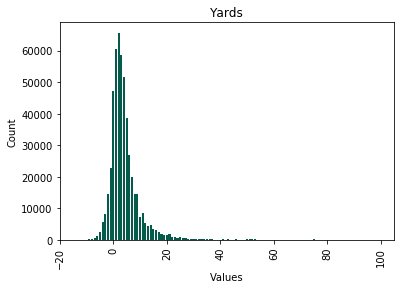

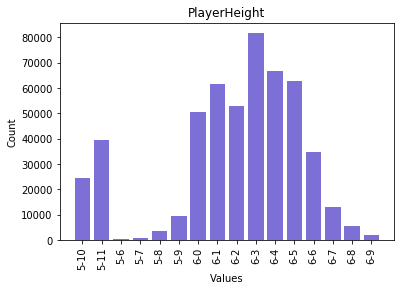

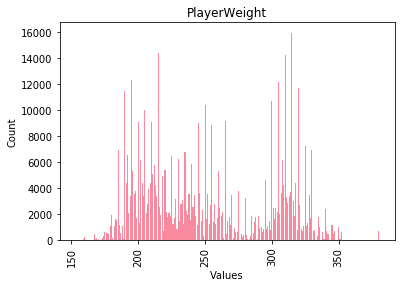

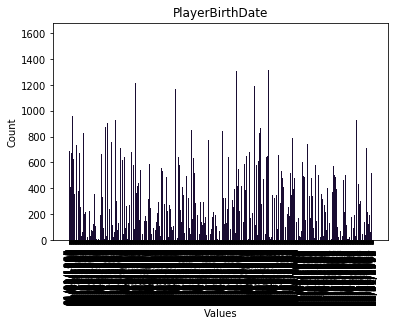

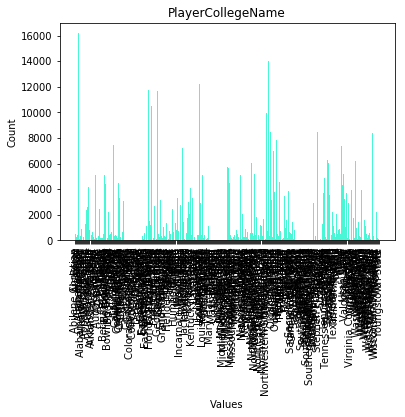

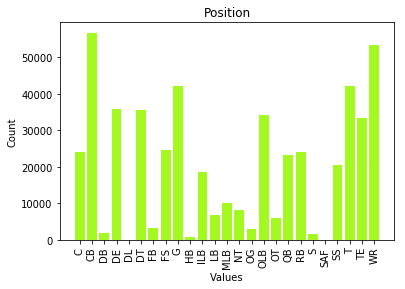

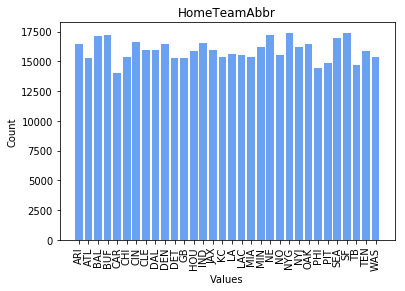

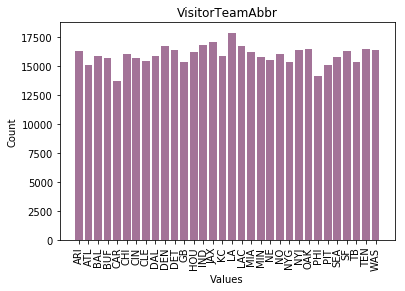

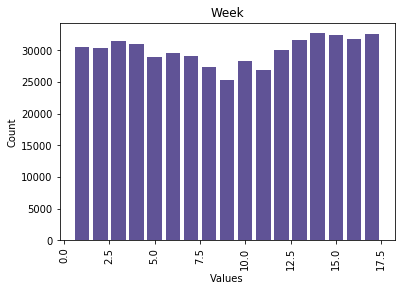

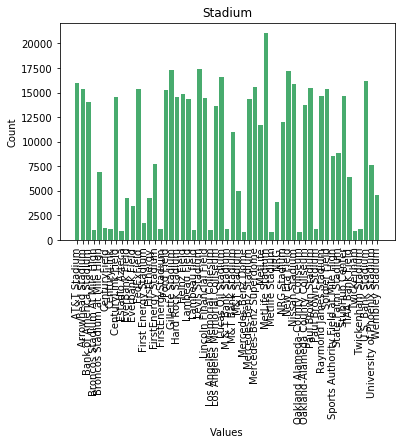

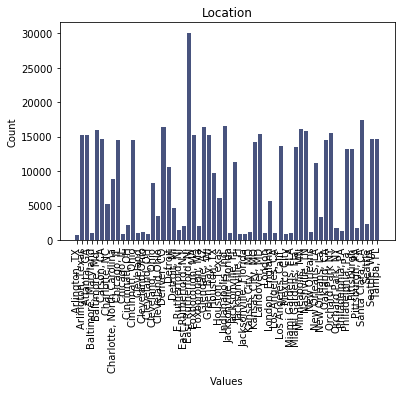

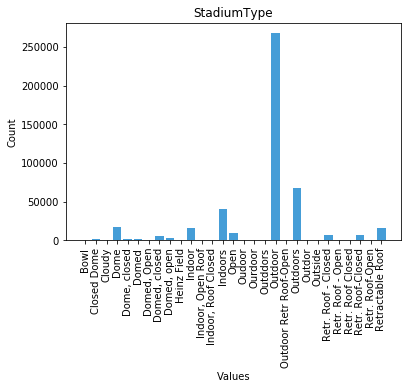

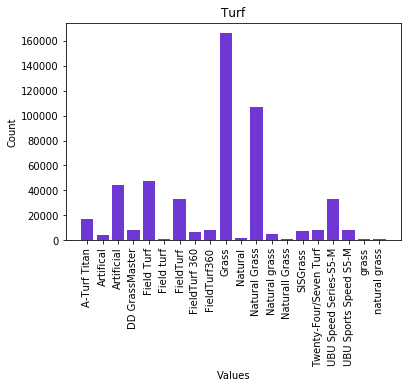

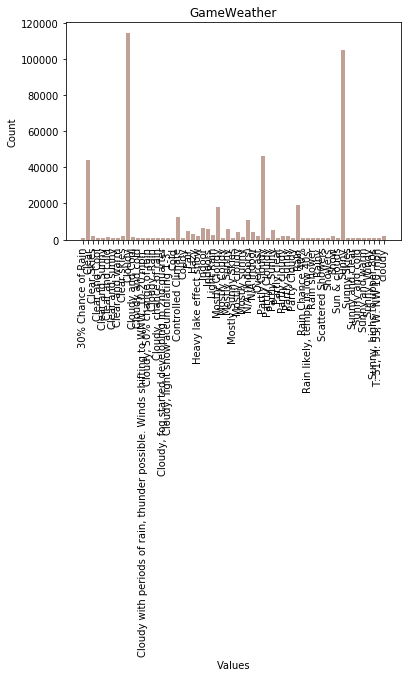

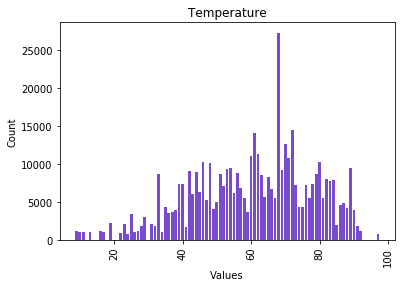

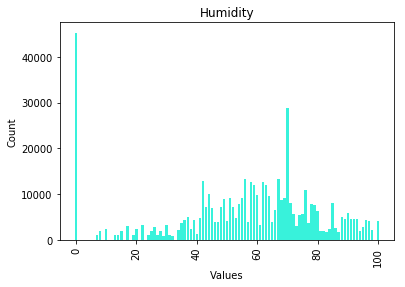

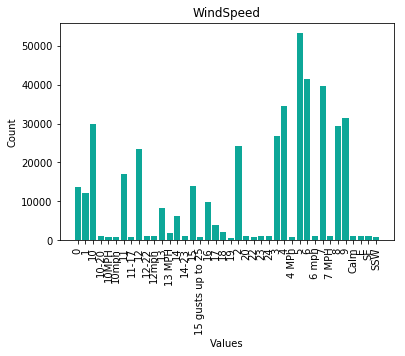

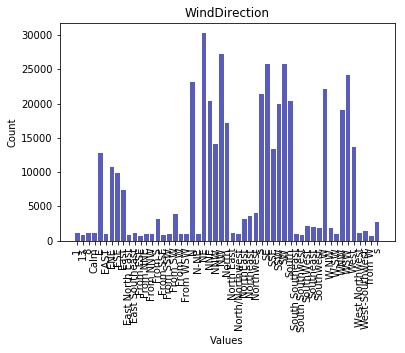

In [29]:
# Visualizing some of the columns
columns_to_vis = ['Team', 'X',
               'Y', 'S', 'A', 'Dis', 'Orientation',
               'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
               'Quarter', 'PossessionTeam', 'Down', 'Distance',
               'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
               'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
               'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'Yards', 
               'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
               'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
               'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
               'Temperature', 'Humidity', 'WindSpeed', 'WindDirection']

"""
WARNING: Code takes long to run...
"""

for column in columns_to_vis:
    grouped = nfl_df.groupby(by = column).count()
    index = grouped.index
    values = np.array(grouped['GameId'])
    ax = plt.subplots(figsize = (6,4))
    ax = plt.bar(x = index, height = values, color = np.random.rand(3,))
    plt.ylabel("Count")
    plt.xlabel("Values")
    plt.xticks(rotation = 'vertical')
    plt.title(column)
    plt.show()
    

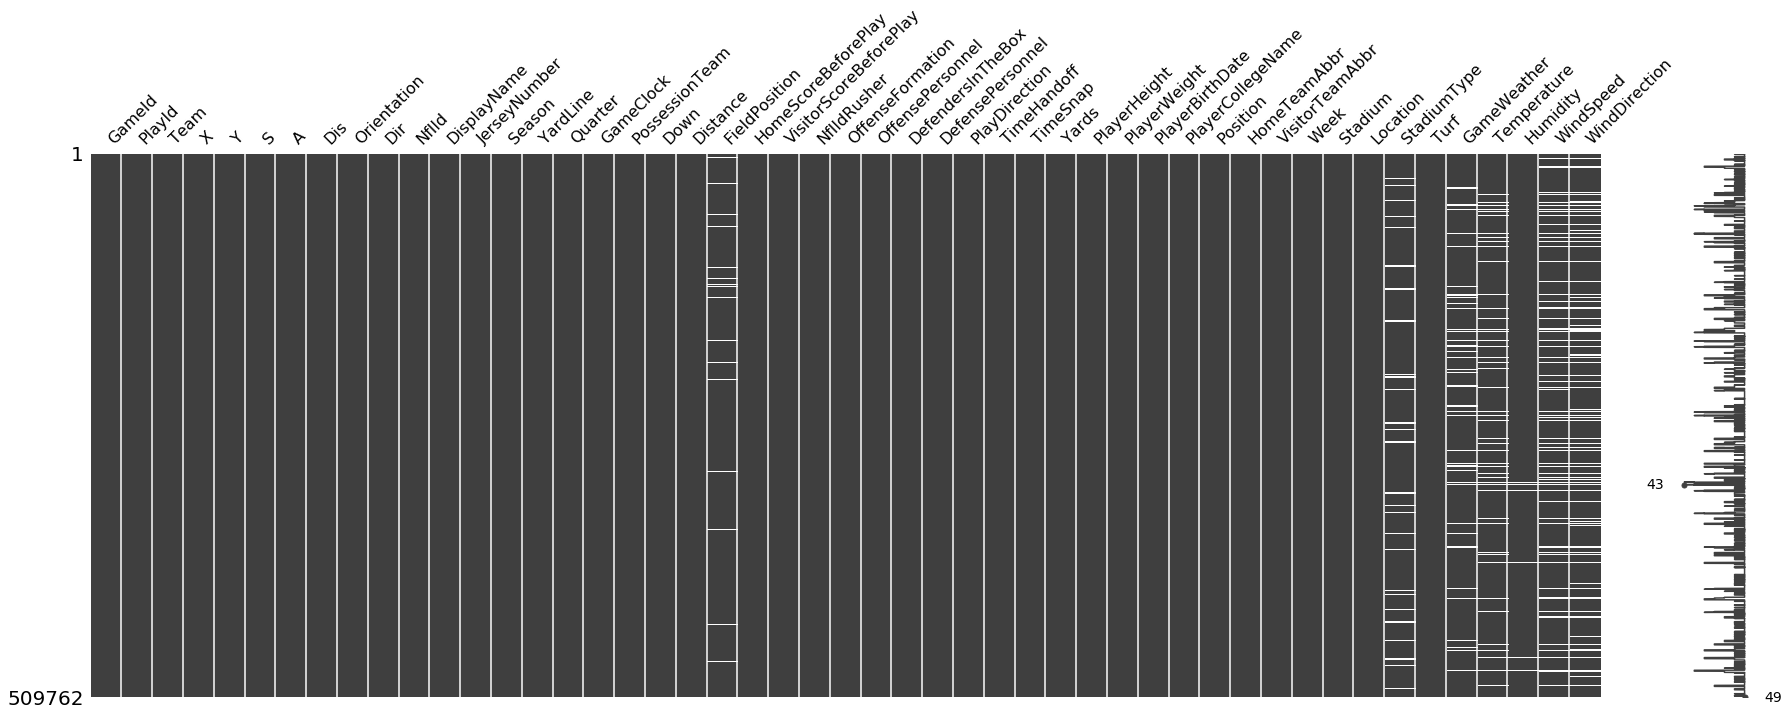

In [12]:
# check missing values
missing_values_count = nfl_df.isnull().sum()
missing_values_count_df = pd.DataFrame(missing_values_count)
missing_values_count_df = missing_values_count_df[missing_values_count_df[0] > 0]
missing_values_count_df.rename(columns = {0: "Number"}, inplace = True)

# Plot graphic of missing values
missingno.matrix(nfl_df, figsize = (30,10))
plt.show()

## 2. Cleaning the data

### Replacing missing values

In [198]:
# Orientation
replace_orientation = nfl_df['Orientation'].mean()
print(f"Replacing missing Orientation values with {replace_orientation}")

# Replace missing values
nfl_df['Orientation'] = nfl_df['Orientation'].fillna(value = replace_orientation, axis = 0)

Replacing missing Orientation values with 180.2477791401154


In [199]:
# Dir
replace_dir = nfl_df['Dir'].mean()
print(f"Replacing missing Dir values with {replace_dir}")

# Replace missing values
nfl_df['Dir'] = nfl_df['Dir'].fillna(value = replace_dir, axis = 0)

Replacing missing Dir values with 179.93385884790536


In [200]:
# FieldPosition
replace_FieldPosition = nfl_df['FieldPosition'].mode()
print(f"Replacing missing FieldPosition values with {replace_FieldPosition[0]}")

# Replace missing values
nfl_df['FieldPosition'] = nfl_df['FieldPosition'].fillna(value = 'BUF', axis = 0)

Replacing missing FieldPosition values with BUF


In [201]:
# OffenseFormation
replace_OffenseFormation = nfl_df['OffenseFormation'].mode()
print(f"Replacing missing OffenseFormation values with {replace_OffenseFormation[0]}")

# Replace missing values
nfl_df['OffenseFormation'] = nfl_df['OffenseFormation'].fillna(value = 'SINGLEBACK', axis = 0)

Replacing missing OffenseFormation values with SINGLEBACK


In [202]:
# DefendersInTheBox
replace_DefendersInTheBox = nfl_df['DefendersInTheBox'].mean()
print(f"Replacing missing DefendersInTheBox values with {replace_DefendersInTheBox}")

# Replace missing values
nfl_df['DefendersInTheBox'] = nfl_df['DefendersInTheBox'].fillna(value = replace_DefendersInTheBox, axis = 0)

Replacing missing DefendersInTheBox values with 6.943024861878453


In [203]:
# StadiumType
replace_StadiumType = nfl_df['StadiumType'].mode()
print(f"Replacing missing StadiumType values with {replace_StadiumType[0]}")

# Replace missing values
nfl_df['StadiumType'] = nfl_df['StadiumType'].fillna(value = 'Outdoor', axis = 0)

Replacing missing StadiumType values with Outdoor


In [204]:
# GameWeather
replace_GameWeather = nfl_df['GameWeather'].mode()
print(f"Replacing missing GameWeather values with {replace_GameWeather[0]}")

# Replace missing values
nfl_df['GameWeather'] = nfl_df['GameWeather'].fillna(value = 'Cloudy', axis = 0)

Replacing missing GameWeather values with Cloudy


In [205]:
# Temperature
replace_Temperature = nfl_df['Temperature'].mean()
print(f"Replacing missing Temperature values with {replace_Temperature}")

# Replace missing values
nfl_df['Temperature'] = nfl_df['Temperature'].fillna(value = replace_Temperature, axis = 0)

Replacing missing Temperature values with 60.4364416885285


In [206]:
# Humidity
replace_Humidity = nfl_df['Humidity'].mean()
print(f"Replacing missing Humidity values with {replace_Humidity}")

# Replace missing values
nfl_df['Humidity'] = nfl_df['Humidity'].fillna(value = replace_Humidity, axis = 0)

Replacing missing Humidity values with 55.646061771001705


In [207]:
# WindSpeed
replace_WindSpeed = nfl_df['WindSpeed'].mode()
print(f"Replacing missing WindSpeed values with {replace_WindSpeed[0]}")

# Replace missing values
nfl_df['WindSpeed'] = nfl_df['WindSpeed'].fillna(value = '5', axis = 0)

Replacing missing WindSpeed values with 5


In [208]:
# WindDirection
replace_WindDirection = nfl_df['WindDirection'].mode()
print(f"Replacing missing WindDirection values with {replace_WindDirection[0]}")

# Replace missing values
nfl_df['WindDirection'] = nfl_df['WindDirection'].fillna(value = 'NE', axis = 0)

Replacing missing WindDirection values with NE


### Text cleaning

In [32]:
# inspecting text in alphanumeric columns - some text preprocessing will be required. This cell helps identify which cells require the preprocessing.

# Removing nan's from the dataframe before doing the check - having nan's prevents us from sorting the list of unique values for each of the investigated features
nfl_df_reduced = nfl_df.dropna(axis = 0)

# Initial check
# alphanumeric_columns = ['Team', 'PossessionTeam', 'DisplayName', 'FieldPosition', 'OffenseFormation', 
#                        'OffensePersonnel', 'DefensePersonnel', 'PlayDirection', 'PlayerHeight',
#                        'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
#                        'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection']

# Refined check
alphanumeric_columns = ['Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'WindSpeed']

for column in alphanumeric_columns:
    list_to_check = nfl_df_reduced[column].unique()
    print(f"{column}:")
    print(sorted(list_to_check))
    print('\n')

Stadium:
['AT&T Stadium', 'Arrowhead Stadium', 'Bank of America Stadium', 'Broncos Stadium At Mile High', 'Broncos Stadium at Mile High', 'CenturyField', 'CenturyLink', 'CenturyLink Field', 'Estadio Azteca', 'EverBank Field', 'Everbank Field', 'FedExField', 'First Energy Stadium', 'FirstEnergy', 'FirstEnergy Stadium', 'FirstEnergyStadium', 'Gillette Stadium', 'Hard Rock Stadium', 'Heinz Field', 'Lambeau Field', 'Lambeau field', 'Levis Stadium', 'Lincoln Financial Field', 'Los Angeles Memorial Coliesum', 'Los Angeles Memorial Coliseum', 'Lucas Oil Stadium', 'M & T Bank Stadium', 'M&T Bank Stadium', 'M&T Stadium', 'Mercedes-Benz Dome', 'Mercedes-Benz Stadium', 'Mercedes-Benz Superdome', 'MetLife', 'MetLife Stadium', 'Metlife Stadium', 'NRG', 'NRG Stadium', 'New Era Field', 'Nissan Stadium', 'Oakland Alameda-County Coliseum', 'Oakland-Alameda County Coliseum', 'Paul Brown Stadium', 'Paul Brown Stdium', 'Raymond James Stadium', 'Soldier Field', 'Sports Authority Field at Mile High', 'State

Columns that need some text preprocessing include Stadium, Location, StadiumType, Turf, GameWeather, WindSpeed and WindDirection

In [209]:
# Stadium

print('Unique stadiums before processing:')
print(sorted(list(nfl_df['Stadium'].unique())))
print('\n')

# Convert to lower case
nfl_df['Stadium'] = nfl_df['Stadium'].str.lower()

# remove trailing white spaces
nfl_df['Stadium'] = nfl_df['Stadium'].str.strip()

stadiums = nfl_df['Stadium'].unique()

# print(stadiums)

# The stadiums below have have other entries which are similar and needs to be cleaned
# This step is a bit more manual - you have to skim through the above list (stadiums) to see which stadiums require attention
stadium_list_to_iterate = ['centuryfield', 'firstenergy', 'los angeles memorial coliesum', 'm & t bank stadium',
                          'mercedes-benz dome', 'metlife', 'nrg', 'oakland alameda-county coliseum', 'paul brown stadium',
                          'twickenham']

for stadium in stadium_list_to_iterate:
    # get the top 5 closest matches
    matches = fuzzywuzzy.process.extract(stadium, stadiums, limit=5, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # take a look at them
    print(matches)
    print('\n')

# use the function in the helpers.py script to replace close matches to the shortlisted stadiums
# the min_ratio values are chosen on a case-by-case basis for each stadium in the stadium_list_to_iterate
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='centuryfield', min_ratio = 70)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='firstenergy', min_ratio = 70)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='los angeles memorial coliesum', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='m & t bank stadium', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='mercedes-benz dome', min_ratio = 60)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='metlife', min_ratio = 60)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='nrg', min_ratio = 40)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='oakland-alameda county coliseum', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='paul brown stadium', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Stadium', string_to_match='twickenham', min_ratio = 70)

print('\n')
print('Unique stadiums after processing:')
print(sorted(list(nfl_df['Stadium'].unique())))

Unique stadiums before processing:
['AT&T Stadium', 'Arrowhead Stadium', 'Bank of America Stadium', 'Broncos Stadium At Mile High', 'Broncos Stadium at Mile High', 'CenturyField', 'CenturyLink', 'CenturyLink Field', 'Estadio Azteca', 'EverBank Field', 'Everbank Field', 'FedExField', 'First Energy Stadium', 'FirstEnergy', 'FirstEnergy Stadium', 'FirstEnergyStadium', 'Ford Field', 'Gillette Stadium', 'Hard Rock Stadium', 'Heinz Field', 'Lambeau Field', 'Lambeau field', 'Levis Stadium', 'Lincoln Financial Field', 'Los Angeles Memorial Coliesum', 'Los Angeles Memorial Coliseum', 'Lucas Oil Stadium', 'M & T Bank Stadium', 'M&T Bank Stadium', 'M&T Stadium', 'Mercedes-Benz Dome', 'Mercedes-Benz Stadium', 'Mercedes-Benz Superdome', 'MetLife', 'MetLife Stadium', 'Metlife Stadium', 'NRG', 'NRG Stadium', 'New Era Field', 'Nissan Stadium', 'Oakland Alameda-County Coliseum', 'Oakland-Alameda County Coliseum', 'Paul Brown Stadium', 'Paul Brown Stdium', 'Raymond James Stadium', 'Soldier Field', 'Spor

In [210]:
# Location

print('Unique locations before processing:')
print(sorted(list(nfl_df['Location'].unique())))
print('\n')

# Convert to lower case
nfl_df['Location'] = nfl_df['Location'].str.lower()

# remove trailing white spaces
nfl_df['Location'] = nfl_df['Location'].str.strip()

locations = nfl_df['Location'].unique()

# The locations below have have other entries which are similar and needs to be cleaned
# This step is a bit more manual - you have to skim through the above list (locations) to see which locations require attention
location_list_to_iterate = ['arlington, texas', 'baltimore, maryland', 'charlotte, nc', 'chicago, il', 'cincinnati, oh',
                           'cleveland', 'detroit', 'e. rutherford, nj', 'houston, texas', 'jacksonville florida',
                           'kansas city,  mo', 'london', 'los angeles, ca', 'miami gardens, fla', 'new orleans', 
                           'orchard park ny', 'philadelphia, pa', 'pittsburgh', 'seattle']

for location in location_list_to_iterate:
    # get the top 5 closest matches
    matches = fuzzywuzzy.process.extract(location, locations, limit=5, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # take a look at them
    print(matches)
    print('\n')

# use the function in the helpers.py script to replace close matches to the shortlisted stadiums
# the min_ratio values are chosen on a case-by-case basis for each stadium in the stadium_list_to_iterate
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='arlington, texas', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='baltimore, maryland', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='charlotte, nc', min_ratio = 60)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='chicago, il', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='cincinnati, oh', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='cleveland', min_ratio = 70)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='detroit', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='e. rutherford, nj', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='houston, texas', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='jacksonville florida', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='kansas city,  mo', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='london', min_ratio = 60)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='los angeles, ca', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='miami gardens, fla', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='new orleans', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='orchard park ny', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='philadelphia, pa', min_ratio = 90)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='pittsburgh', min_ratio = 80)
helpers.replace_matches_in_column(df=nfl_df, column='Location', string_to_match='seattle', min_ratio = 80)

print('\n')
print('Unique locations after processing:')
print(sorted(list(nfl_df['Location'].unique())))

Unique locations before processing:
['Arlington, TX', 'Arlington, Texas', 'Atlanta, GA', 'Baltimore, Maryland', 'Baltimore, Md.', 'Carson, CA', 'Charlotte, NC', 'Charlotte, North Carolina', 'Chicago, IL', 'Chicago. IL', 'Cincinnati, OH', 'Cincinnati, Ohio', 'Cleveland', 'Cleveland Ohio', 'Cleveland, OH', 'Cleveland, Ohio', 'Cleveland,Ohio', 'Denver, CO', 'Detroit', 'Detroit, MI', 'E. Rutherford, NJ', 'East Rutherford, N.J.', 'East Rutherford, NJ', 'Foxborough, MA', 'Foxborough, Ma', 'Glendale, AZ', 'Green Bay, WI', 'Houston, TX', 'Houston, Texas', 'Indianapolis, Ind.', 'Jacksonville Florida', 'Jacksonville, FL', 'Jacksonville, Fl', 'Jacksonville, Florida', 'Kansas City,  MO', 'Kansas City, MO', 'Landover, MD', 'London', 'London, England', 'Los Angeles, CA', 'Los Angeles, Calif.', 'Mexico City', 'Miami Gardens, FLA', 'Miami Gardens, Fla.', 'Minneapolis, MN', 'Nashville, TN', 'New Orleans', 'New Orleans, LA', 'New Orleans, La.', 'Oakland, CA', 'Orchard Park NY', 'Orchard Park, NY', 'Phil

In [211]:
# StadiumType

print('Unique StadiumType before processing:')
print(sorted(list(nfl_df['StadiumType'].unique())))
print('\n')

# Stadium types regarded as 'Indoor'
indoor_list = ['Closed Dome', 'Dome', 'Dome, closed', 'Domed', 'Domed, Open', 'Domed, closed', 'Domed, open', 
          'Indoor', 'Indoor, Open Roof', 'Indoor, Roof Closed', 'Indoors', 'Retr. Roof - Closed', 
          'Retr. Roof Closed', 'Retr. Roof-Closed', 'Retractable Roof']

# Stadium types regarded as 'Outdoor'
outdoor_list = ['Bowl', 'Cloudy', 'Open', 'Oudoor', 'Ourdoor', 'Outddors', 'Outdoor', 'Outdoor Retr Roof-Open', 
          'Outdoors', 'Outdor', 'Outside', 'Retr. Roof - Open', 'Retr. Roof-Open']

# Indoors vs Outdoors (if indoor then 0, else 1)
nfl_df['StadiumTypeNew'] = nfl_df['StadiumType'].apply(lambda x: 0 if x in indoor_list else 1)

nfl_df.drop(columns = ['StadiumType'], axis = 1, inplace = True)
nfl_df.rename(columns = {'StadiumTypeNew': 'StadiumType'}, inplace = True)

Unique StadiumType before processing:
['Bowl', 'Closed Dome', 'Cloudy', 'Dome', 'Dome, closed', 'Domed', 'Domed, Open', 'Domed, closed', 'Domed, open', 'Heinz Field', 'Indoor', 'Indoor, Open Roof', 'Indoor, Roof Closed', 'Indoors', 'Open', 'Oudoor', 'Ourdoor', 'Outddors', 'Outdoor', 'Outdoor Retr Roof-Open', 'Outdoors', 'Outdor', 'Outside', 'Retr. Roof - Closed', 'Retr. Roof - Open', 'Retr. Roof Closed', 'Retr. Roof-Closed', 'Retr. Roof-Open', 'Retractable Roof']




In [212]:
# Turf
print('Unique Turf before processing:')
print(sorted(list(nfl_df['Turf'].unique())))
print('\n')

# Turf types regarded as 'artificial'
artificial_turf = ['A-Turf Titan', 'Artifical', 'Artificial', 'DD GrassMaster', 'Field Turf', 'Field turf', 'FieldTurf', 
                   'FieldTurf 360', 'FieldTurf360', 'Twenty-Four/Seven Turf', 'UBU Speed Series-S5-M', 'UBU Sports Speed S5-M']

# artificial or natural (0 if natural, 1 if artificial)
nfl_df['TurfNew'] = nfl_df['Turf'].apply(lambda x: 1 if x in artificial_turf else 0)

nfl_df.drop(columns = ['Turf'], axis = 1, inplace = True)
nfl_df.rename(columns = {'TurfNew': 'Turf'}, inplace = True)

Unique Turf before processing:
['A-Turf Titan', 'Artifical', 'Artificial', 'DD GrassMaster', 'Field Turf', 'Field turf', 'FieldTurf', 'FieldTurf 360', 'FieldTurf360', 'Grass', 'Natural', 'Natural Grass', 'Natural grass', 'Naturall Grass', 'SISGrass', 'Twenty-Four/Seven Turf', 'UBU Speed Series-S5-M', 'UBU Sports Speed S5-M', 'grass', 'natural grass']




In [213]:
# GameWeather
print('Unique GameWeather before processing:')
print(sorted(list(nfl_df['GameWeather'].unique())))
print('\n')

# Cloudy
cloudy_list = ['Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 
               'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.', 
               'Cloudy, 50% change of rain', 'Cloudy, Rain', 'Cloudy, chance of rain', 'Cloudy, fog started developing in 2nd quarter',
               'Cloudy, light snow accumulating 1-3"', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly cloudy',
               'Overcast', 'Partly Cloudy', 'Partly Clouidy', 'Partly cloudy', 'Party Cloudy', 'cloudy']

# Rain
rainy_list = ['Light Rain', 'Rain', 'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 
              'Scattered Showers', 'Showers', ]

# Clear
clear_list = ['Clear', 'Clear Skies', 'Clear and Cool', 'Clear and Sunny', 'Clear and cold', 'Clear and sunny', 
              'Clear and warm', 'Clear skies', 'Mostly Sunny', 'Mostly Sunny Skies', 'Mostly sunny', 
              'Partly Sunny', 'Partly clear', 'Partly sunny', 'Sunny', 'Sunny Skies', 'Sunny and clear', 'Sunny and cold', 'Sunny and warm', 'Sunny, Windy', 
              'Sunny, highs to upper 80s']

# Other
other_list = ['30% Chance of Rain', 'Cold', 'Controlled Climate', 'Coudy', 'Fair', 'Hazy', 'Heavy lake effect snow', 
              'Indoor', 'Indoors', 'N/A (Indoors)', 'N/A Indoor', 'Snow', 'Sun & clouds', 'T: 51; H: 55; W: NW 10 mph']

# Cloudy (0), rain (1), clear (2), other (3)
nfl_df['GameWeatherNew'] = nfl_df['GameWeather'].apply(lambda x: 0 if x in cloudy_list else
                                                      (1 if x in rainy_list else
                                                      (2 if x in clear_list else
                                                      (3 if x in other_list else -1))))

nfl_df.drop(columns = ['GameWeather'], axis = 1, inplace = True)
nfl_df.rename(columns = {'GameWeatherNew': 'GameWeather'}, inplace = True)

Unique GameWeather before processing:
['30% Chance of Rain', 'Clear', 'Clear Skies', 'Clear and Cool', 'Clear and Sunny', 'Clear and cold', 'Clear and sunny', 'Clear and warm', 'Clear skies', 'Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.', 'Cloudy, 50% change of rain', 'Cloudy, Rain', 'Cloudy, chance of rain', 'Cloudy, fog started developing in 2nd quarter', 'Cloudy, light snow accumulating 1-3"', 'Cold', 'Controlled Climate', 'Coudy', 'Fair', 'Hazy', 'Heavy lake effect snow', 'Indoor', 'Indoors', 'Light Rain', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly Sunny', 'Mostly Sunny Skies', 'Mostly cloudy', 'Mostly sunny', 'N/A (Indoors)', 'N/A Indoor', 'Overcast', 'Partly Cloudy', 'Partly Clouidy', 'Partly Sunny', 'Partly clear', 'Partly cloudy', 'Partly sunny', 'Party Cloudy', 'Rain', 'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rain shower', 'Rainy', 'Scattered Showers', 'Showers', 'Snow', 'Sun & clou

In [214]:
# WindSpeed
print('Unique WindSpeed before processing:')
print(sorted(list(nfl_df['WindSpeed'].unique())))
print('\n')

# 0 if slow, 1 if fast, 2 if unknown
# 0 - 10mph
slow_list = ['0', '1', '10', '10MPH', '10mph', '2', '3', '4', '4 MPh', '5', '6', '6 mph', '7', '7 MPH', '8', '9', 'Calm']

# Unknown 
unknown_list = ['E', 'SE', 'SSW']

nfl_df['WindSpeedNew'] = nfl_df['WindSpeed'].apply(lambda x: 0 if x in slow_list else 
                                                   (2 if x in unknown_list else 1))
nfl_df.drop(columns = ['WindSpeed'], axis = 1, inplace = True)
nfl_df.rename(columns = {'WindSpeedNew': 'WindSpeed'}, inplace = True)


Unique WindSpeed before processing:
['0', '1', '10', '10-20', '10MPH', '10mph', '11', '11-17', '12', '12-22', '12mph', '13', '13 MPH', '14', '14-23', '15', '15 gusts up to 25', '16', '17', '18', '19', '2', '20', '22', '23', '24', '3', '4', '4 MPh', '5', '6', '6 mph', '7', '7 MPH', '8', '9', 'Calm', 'E', 'SE', 'SSW']




## 3. Feature engineering

### Aggregating the data

The original dataset contains a row for each unique combination of GameId, PlayId and NflId. This means that each play has multiple rows, with each row containing details of a different player involved in that particular play. It should be noted that rows pertaining to the same GameId and PlayId have many overlapping data entries. For example, two rows related to the same GameId and PlayId will have the same values for Stadium, Temperature, FieldPosition and Location, but they will have different values for DisplayName and PlayerWeight. In effect, we have extensive duplication across the rows of this dataset. An important step in this modelling exercise is deciding how rows related to the same ame and play will be aggregated.

In this project, all rows pertaining to a specific GameId and PlayId will be combined into one. The following feature values will not be affected by the combination (i.e. these rows have same values across all rows to start with) and their values will be retained in the single remaining row:
- GameId
- PlayId
- Season
- YardLine
- Quarter
- GameClock
- PossessionTeam
- Down
- Distance
- FieldPosition
- HomeScoreBeforePlay
- VisitorScoreBeforePlay
- OffenseFormation
- OffensePersonnel
- DefendersInTheBox
- DefensePersonnel
- PlayDirection
- TimeHandoff
- TimeSnap
- HomeTeamAbbr
- VisitorTeamAbbr
- Week
- Stadium
- Location
- StadiumType
- Turf
- GameWeather
- Temperature
- Humidity
- WindSpeed 
- WindDirection
- NflIdRusher
- Yards: This is the response variable and is the same for a specific set of GameId and PlayId values, regardless of the player's details in a particular row in the original dataset.

The following features, which do not have the same values across mutliple rows for the same GameId and PlayId, will be dealt with as follows:
- OffenseTeam (based on the 'Team' column): 'Home' or 'Away' based on the offensive team. For each row, we want a value 'Home' or 'Away' based on who is the attacking team
- X (player position along the long axis of the field): Average of X values of all players involved in that play **
- Y (player position along the short axis of the field): Average of Y values of all players involved in that play **
- S (speed in yards/second): Average of S values of all players involved in that play **
- A (acceleration in yards/second^2): Average of A values of all players involved in that play **
- Dis (distance traveled from prior time point, in yards): Average of Dis values of all players involved in that play **
- Orientation (orientation of player (deg)): Average of Orientation values of all players involved in that play **
- Dir (angle of player motion (deg)): Average of Dir values of all players involved in that play **
- NflId: Quarterback's NflId to be used here. Quarterbacks play pivotal roles in NFL game outcomes and will hence weigh more in the model's predition **
- DisplayName: Quarterback's name to be used here for the same reason as above **
- JerseyNumber: Average of JerseyNumber values of all players involved in that play **
- PlayerHeight: Mode of PlayerHeight values of all players involved in that play **
- PlayerWeight: Average of PlayerWeight values of all players involved in that play **
- PlayerBirthDate: Converted into an average of player ages of all players involved in that play **
- PlayerCollegeName: Mode of PlayerCollegeName feature **
- Position: Mode of Position feature **

** Split by attacking AND defending team

In [215]:
# Before aggregating the data in the cells below, we'll first need to convert the PlayerBirthDate feature into an (integer) age that can be interpreted by the model
nfl_df['PlayerAgeYear'] = nfl_df['PlayerBirthDate'].apply(lambda x: int(x[-4:]))
nfl_df['PlayerAge'] = nfl_df['Season'] - nfl_df['PlayerAgeYear']

In [216]:
# Creating a test dataframe with only one play's records (22 rows per play) that will be used to test if aggregation_func, the function used to aggregate the data, works as intended
test_aggr = nfl_df[nfl_df['PlayId'] == 20170907000118]
test_aggr.T

# Testing the output of aggregation_func
test_df = helpers.aggregation_func(nfl_df, test_aggr)

In [217]:
# Checking the total number of rows in the original dataframe
nfl_df_rows = len(nfl_df)
print(nfl_df.shape)

(509762, 51)


In [219]:
# Passing the full dataframe to the aggregation_func for processing
# WARNING: This cell takes long to run
nfl_df_aggregated = helpers.aggregation_func(nfl_df, nfl_df)
nfl_df_aggregated.head()

,GameId,PlayId,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,...,PlayerHeight_off,PlayerHeight_def,PlayerWeight_off,PlayerWeight_def,PlayerAge_off,PlayerAge_def,PlayerCollegeName_off,PlayerCollegeName_def,Position_off,Position_def
0,2017090700,20170907000118,2017,35,1,14:14:00,NE,3,2,NE,...,5-10,6-0,259.181818,233.545455,28.272727,27.363636,Arizona,Auburn,WR,CB
22,2017090700,20170907000139,2017,43,1,13:52:00,NE,1,10,NE,...,5-10,6-0,259.181818,233.545455,28.272727,27.363636,Arizona,Auburn,WR,CB
44,2017090700,20170907000189,2017,35,1,13:02:00,NE,1,10,KC,...,5-10,6-0,259.181818,233.545455,28.272727,27.363636,Arizona,Auburn,WR,CB
66,2017090700,20170907000345,2017,2,1,12:12:00,NE,2,2,KC,...,6-6,6-3,282.545455,257.454545,28.090909,28.272727,Arizona,Georgia,T,DE
88,2017090700,20170907000395,2017,25,1,12:08:00,KC,1,10,KC,...,6-5,5-11,268.454545,242.454545,26.363636,27.000000,California,Rutgers,T,CB


In [222]:
# Checking the total number of rows in the aggregated dataframe
# There are 22 rows per play - seeing that each play is reduced into a single row, we expect to see the total 
# number of rows reduce by a factor of 22 (if there are exactly 22 rows per PlayId)
nfl_df_aggregated_rows = len(nfl_df_aggregated)
factor = nfl_df_rows/nfl_df_aggregated_rows
print(nfl_df_aggregated.shape)
print(factor)

(23171, 64)
22.0


From the above we can see that by running the aggregation function on the initial dataframe we reduce the total number of rows by a factor of 22 as expected.

In [224]:
# Saving the aggregated dataframe to a pickle file for ease of use
nfl_df_aggregated.to_pickle('nfl_df_aggregated.pkl')

In [21]:
# Read the pickle file
nfl_df_aggregated_pkl = pd.read_pickle('nfl_df_aggregated.pkl')
print(nfl_df_aggregated_pkl.shape)

(23171, 64)


### Dropping redundant columns

In [22]:
print(f"Columns before dropping: {len(nfl_df_aggregated_pkl.columns)}")

# Remove columns that will not be feature engineered any further and that will be excluded from the subsequent analysis
columns_to_remove = ['GameId', 'PlayId', 'GameClock', 'TimeHandoff', 'TimeSnap', 'WindDirection', 'DisplayName_off', 'DisplayName_def']

"""
DisplayName was removed since its effect will be caught up by the model in the NflId variable - we can simply map from 
the NflId variable if we wanted to see specific names.
"""

for column in columns_to_remove:
    nfl_df_aggregated_pkl.drop(columns = column, axis = 1, inplace = True)
    
print(f"Columns after dropping: {len(nfl_df_aggregated_pkl.columns)}")

Columns before dropping: 64
Columns after dropping: 56


## 4. Feature selection

### Correlation analysis: Investigating correlations between independent variables

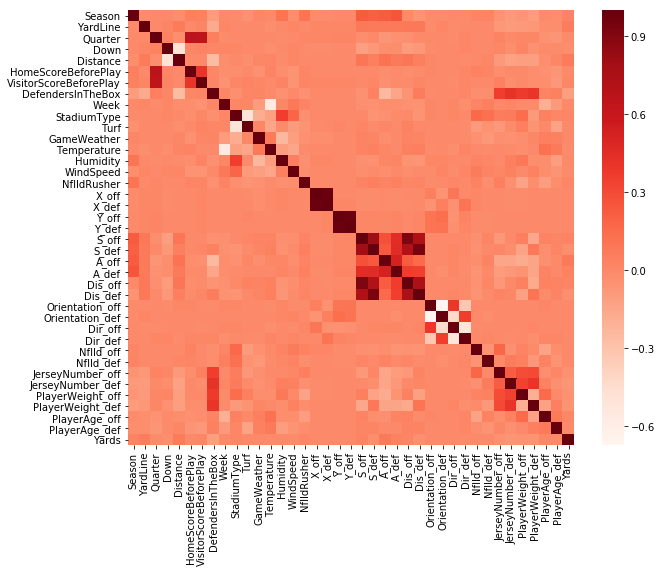

In [7]:
#Using Pearson Correlation
plt.figure(figsize=(10,8))
cor = nfl_df_aggregated_pkl.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

A function was created (see the 'helpers.py' file, 'correlation' function) that calculates the pairwise correlations and adds the columns to the list of correlated features if the correlation exceeds a threshold. It returns a list of pairwise features that have a correlation above the threshold.

In [36]:
# Using the aforementioned function to get a list of correlated variables
helpers.correlation(nfl_df_aggregated_pkl, 0.7)

{'S_def-S_off', 'X_def-X_off', 'Dis_off-S_off', 'Dis_def-Dis_off', 'Y_def-Y_off', 'Dis_def-S_def', 'Dis_off-S_def', 'Dis_def-S_off'}


The above correlated pairs of features will be used to determine which features to exclude. But first, we check what each of the independent variables' correlation is with the target variable. This will help us decide which of the two highly correlated features (shown in the above list) in the pair should be excluded. The goal of this step is to ensure that the feature with the lowest correlation with the target variable is dropped, and not the one with the highest correlation with the target variable.

In [37]:
#Correlation with output variable
cor = nfl_df_aggregated_pkl.corr()
cor_target = abs(cor["Yards"])
print(cor_target)

Season                    0.031350
YardLine                  0.064551
Quarter                   0.006733
Down                      0.021672
Distance                  0.071936
HomeScoreBeforePlay       0.004706
VisitorScoreBeforePlay    0.009084
DefendersInTheBox         0.109212
Week                      0.003265
StadiumType               0.013535
Turf                      0.001290
GameWeather               0.001474
Temperature               0.011835
Humidity                  0.003864
WindSpeed                 0.007993
NflIdRusher               0.018997
Yards                     1.000000
X_off                     0.000801
X_def                     0.000695
Y_off                     0.000842
Y_def                     0.000732
S_off                     0.027434
S_def                     0.023334
A_off                     0.079825
A_def                     0.033710
Dis_off                   0.024932
Dis_def                   0.026401
Orientation_off           0.006046
Orientation_def     

In [23]:
# From the above two cells we arrive at the following list of features to be dropped:

"""
Some judgement was used here to determine which of the correlated variables above should be excluded. A correlation of 0.7 was used
for this, but could easily be increased/decreased based on personal preference.
"""
corr_features_to_drop = ['Y_def', 'S_def', 'Dis_off', 'X_def']

nfl_df_reduced = nfl_df_aggregated_pkl.drop(columns = corr_features_to_drop, axis = 1)

## 5. Final data preparation steps before building the model

### Encoding categorical variables

In [24]:
# Encoding categorical features
columns_to_encode = ['PossessionTeam', 'FieldPosition', 'OffenseFormation', 'OffensePersonnel', 'DefensePersonnel', 'PlayDirection', 'HomeTeamAbbr', 'VisitorTeamAbbr',
                    'Stadium', 'Location', 'OffenseTeam', 'PlayerHeight_off', 'PlayerHeight_def', 'PlayerCollegeName_off', 'PlayerCollegeName_def', 'Position_off', 'Position_def']

nfl_df_reduced_encoded = pd.get_dummies(nfl_df_reduced, prefix = columns_to_encode, columns = columns_to_encode)
nfl_df_reduced_encoded.head()

,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,Week,StadiumType,...,Position_def_ILB,Position_def_LB,Position_def_MLB,Position_def_NT,Position_def_OLB,Position_def_RB,Position_def_SS,Position_def_T,Position_def_TE,Position_def_WR
0,2017,35,1,3,2,0,0,6.0,1,1,...,0,0,0,0,0,0,0,0,0,0
22,2017,43,1,1,10,0,0,6.0,1,1,...,0,0,0,0,0,0,0,0,0,0
44,2017,35,1,1,10,0,0,7.0,1,1,...,0,0,0,0,0,0,0,0,0,0
66,2017,2,1,2,2,0,0,9.0,1,1,...,0,0,0,0,0,0,0,0,0,0
88,2017,25,1,1,10,7,0,7.0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Ensuring that the dependent variable is the last column of the dataframe - this makes it easier to ID the dependent variable
nfl_df_reduced_encoded['YardsNew'] = nfl_df_reduced_encoded['Yards'].apply(lambda x: x)
nfl_df_reduced_encoded.drop(columns = ['Yards'], axis = 1, inplace = True)
nfl_df_reduced_encoded.rename(columns = {'YardsNew': 'Yards'}, inplace = True)

In [26]:
nfl_df_reduced_encoded.shape

# We have roughly 23000 rows with over 600 columns after preprocessing the data

(23171, 619)

In [27]:
# Saving the aggregated dataframe to a pickle file for ease of use - this is the FINAL dataframe that will be split, scaled and fed to the models
nfl_df_reduced_encoded.to_pickle('nfl_df_reduced_encoded.pkl')

In [28]:
# Read the pickle file
nfl_df_reduced_encoded_pkl = pd.read_pickle('nfl_df_reduced_encoded.pkl')
print(nfl_df_reduced_encoded_pkl.shape)

(23171, 619)


### Splitting the dataset into a training, validation and test dataset

In [29]:
# 1. First we package up the input data and the target variable as pandas dataframes. This
# will make saving the data to a file a little easier later on.

from sklearn import model_selection

X_total = nfl_df_reduced_encoded.drop(columns = 'Yards')
Y_total = pd.DataFrame(nfl_df_reduced_encoded['Yards'])

# We split the dataset into 80% training and 20% testing sets.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_total, Y_total, test_size=0.2)

# Then we split the training set further into 80% training and 20% validation sets.
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, test_size=0.2)

# 2. This is our local data directory. We need to make sure that it exists.
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# 3. We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

# 4. Upload to S3
prefix = 'nfl_capstone_project'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape)

(14828, 618) (14828, 1)
(4635, 618) (4635, 1)
(3708, 618) (3708, 1)


### Scaling the numerical variables

In [30]:
# scale numerical features into a normalized range, 0-1. The scaled values will be used by the simple linear regression model
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

from sklearn.preprocessing import MinMaxScaler

# scaling the x and y values
scaler=MinMaxScaler()
scaler2 = MinMaxScaler()

# Training set - fitting the scaler to the training data
"""
We fit the scaler to the training data only. This is to ensure that the minimum and maximum values used in the scaling are taken from the training data only. If we were to use the full
dataset to fit the scaler, we might have the minimum and maximum values of the test or validation set 'leak' into the training data. In a 'real-world' scenario, the data of the test set would not
be available to scale the training data with, so we want to prevent this 'leakage'.
"""
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
Y_train_scaled = pd.DataFrame(scaler2.fit_transform(Y_train))

# Testing set
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
Y_test_scaled = pd.DataFrame(scaler2.transform(Y_test))

# Validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val))
Y_val_scaled = pd.DataFrame(scaler2.transform(Y_val))

# Saving the scaled dataframes to S3
X_test_scaled.to_csv(os.path.join(data_dir, 'test_scaled.csv'), header=False, index=False)
pd.concat([Y_val_scaled, X_val_scaled], axis=1).to_csv(os.path.join(data_dir, 'validation_scaled.csv'), header=False, index=False)
pd.concat([Y_train_scaled, X_train_scaled], axis=1).to_csv(os.path.join(data_dir, 'train_scaled.csv'), header=False, index=False)

test_location_scaled = sagemaker_session.upload_data(os.path.join(data_dir, 'test_scaled.csv'), key_prefix=prefix)
val_location_scaled = sagemaker_session.upload_data(os.path.join(data_dir, 'validation_scaled.csv'), key_prefix=prefix)
train_location_scaled = sagemaker_session.upload_data(os.path.join(data_dir, 'train_scaled.csv'), key_prefix=prefix)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 6. Creating the model

### Benchmark model - Simple Linear Regression model

In [60]:
# instantiate a LinearLearner
# import LinearLearner
from sagemaker import LinearLearner

output_path = 's3://{}/{}'.format(bucket, prefix)

linear_model = LinearLearner(role=role,
                              train_instance_count=1, 
                              train_instance_type='ml.c4.xlarge',
                              predictor_type='regressor',
                              output_path=output_path,
                              sagemaker_session=sagemaker_session,
                              epochs=15)


In [61]:
# convert features/labels to numpy arrays using the scaled data created above
X_train_scaled_np = np.array(X_train_scaled.astype('float32'))
Y_train_scaled_np = np.squeeze(np.array(Y_train_scaled.astype('float32'))) # need a vector instead of matrix format - use np.squeeze

# create RecordSet
formatted_train_data_scaled = linear_model.record_set(X_train_scaled_np, labels=Y_train_scaled_np)

In [62]:
%%time 
# train the estimator on formatted training data
linear_model.fit(formatted_train_data_scaled)

2019-12-12 15:24:05 Starting - Starting the training job...
2019-12-12 15:24:07 Starting - Launching requested ML instances...
2019-12-12 15:25:04 Starting - Preparing the instances for training.........
2019-12-12 15:26:30 Downloading - Downloading input data
2019-12-12 15:26:30 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/12/2019 15:26:47 INFO 140501704681280] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'au

### XGBoost model

In [31]:
# As stated above, we use this utility method to construct the image name for the training container.
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [32]:
# Setting the hyperparameters - these will serve as default values
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [33]:
# Hyperparameter tuning
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [36]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format. We pass the unscaled/original training and validation data when using the XGBoost model
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

# First, we fit a general model ('untuned') with predefined hyperparameters. This model will be compared to a hyperparameter-tuned model later
# Untuned model is fit
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-12-12 14:39:05 Starting - Starting the training job...
2019-12-12 14:39:06 Starting - Launching requested ML instances...
2019-12-12 14:40:01 Starting - Preparing the instances for training......
2019-12-12 14:40:53 Downloading - Downloading input data...
2019-12-12 14:41:11 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[14:41:42] 14828x618 matrix with 9163704 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV 

In [37]:
# Fitting different 'tuned' models, each with a different set of hyperparameters
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

# Notify us when the model fitting is complete
xgb_hyperparameter_tuner.wait()

..............................................................................................................................................................................................................................................................................!


In [38]:
# Retrieving information about the best performing model
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191212-1443-019-91166d9d'

In [39]:
# Constructing a new estimator object from the results of the best training job
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-12-12 15:06:12 Starting - Preparing the instances for training
2019-12-12 15:06:12 Downloading - Downloading input data
2019-12-12 15:06:12 Training - Training image download completed. Training in progress.
2019-12-12 15:06:12 Uploading - Uploading generated training model
2019-12-12 15:06:12 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[15:05:55] 1

## 7. Evaluating the models

### Benchmark model - Simple Linear Regression model

In [63]:
# Testing our benchmark model using AWS's Batch Transform Functionality. First, we build a transformer object from our fit model
linear_transformer = linear_model.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [64]:
# Running the batch tranform job
linear_transformer.transform(test_location_scaled, content_type='text/csv', split_type='Line')
linear_transformer.wait()

.....................
Docker entrypoint called with argument(s): serve
[12/12/2019 15:30:48 INFO 140625917925184] loaded entry point class algorithm.serve.server_config:config_api
[12/12/2019 15:30:48 INFO 140625917925184] loading entry points
[12/12/2019 15:30:48 INFO 140625917925184] loaded request iterator text/csv
[12/12/2019 15:30:48 INFO 140625917925184] loaded request iterator application/x-recordio-protobuf
[12/12/2019 15:30:48 INFO 140625917925184] loaded request iterator application/json
[12/12/2019 15:30:48 INFO 140625917925184] loaded request iterator application/jsonlines
[12/12/2019 15:30:48 INFO 140625917925184] loaded response encoder text/csv
[12/12/2019 15:30:48 INFO 140625917925184] loaded response encoder application/x-recordio-protobuf
[12/12/2019 15:30:48 INFO 140625917925184] loaded response encoder application/json
[12/12/2019 15:30:48 INFO 140625917925184] loaded response encoder application/jsonlines
[12/12/2019 15:30:48 INFO 140625917925184] loaded entry poin

In [65]:
# Using a bit of notebook magic to copy the output file from its S3 location and save it locally.
!aws s3 cp --recursive $linear_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-961021140576/linear-learner-2019-12-12-15-27-29-326/test_scaled.csv.out to ../data/test_scaled.csv.out


In [66]:
# Reading the predicted yardages
Y_pred_test_linear = pd.read_csv(os.path.join(data_dir, 'test_scaled.csv.out'), header=None)

# We need to convert the predicted yardages into an array - the current format of Y_pred_test_scaled is not useable
list_of_linear_predictions = []
for i in range(len(Y_pred_test_linear[0])):
    list_of_linear_predictions.append(float(Y_pred_test_linear[0][i][10:-1]))

Y_pred_test_linear = np.array(list_of_linear_predictions).reshape(-1, 1)

In [67]:
# Seeing that we scaled the yardages on which the LinearLearner model was built, we need to inverse transform the predictions back to its original scale in order to interpret the predictions
Y_pred_test_inverse = scaler2.inverse_transform(Y_pred_test_linear)

"""
Actual yardages predicted by the LinearLearner are shown below.
"""

Y_pred_test_inverse

array([[1.22903425],
       [3.83562517],
       [3.20982088],
       ...,
       [3.44556567],
       [4.95458321],
       [5.16071783]])

In [68]:
print(min(Y_pred_test_inverse), max(Y_pred_test_inverse))

[-3.4489789] [16.19500017]


[-3.4489789] [16.19500017]


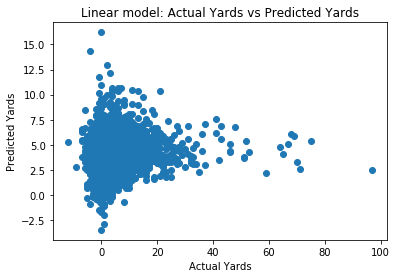

<Figure size 576x432 with 0 Axes>

In [69]:
# Plotting the predicted yardages against the actual yardages - if the model was perfect, we'd expect to see a the resulting scatter plot would look like the line x=y.
# We notice that the model is in fact not perfect. We will use the Root Mean Square Error (RMSE) as the single metric to evaluate the model performance.
print(min(Y_pred_test_inverse), max(Y_pred_test_inverse))
"""
Notice how the LinearLearner model predicts all the observations in the approximate range [-3, 16].
"""
plt.scatter(np.array(Y_test), Y_pred_test_inverse)
plt.xlabel("Actual Yards")
plt.ylabel("Predicted Yards")
plt.title("Linear model: Actual Yards vs Predicted Yards")
plt.figure(figsize=(8,6))
plt.show()

In [70]:
# Creating a dataframe that will be passed to the 'rmse' function that calculates the RMSE for the models
# This dataframe simply contains two columns - one for the actual yards gained/lost in the the play, and another for the predicted yards gained/lost in the play
linear_rmse = Y_test
linear_rmse = linear_rmse.rename(columns = {'Yards': 'Actual Yards'})
linear_rmse['Predicted Yards'] = Y_pred_test_inverse

print(f"The RMSE for the simple linear regression model (benchmark model) is {round(rmse(helpers.linear_rmse),2)}.")

The RMSE for the simple linear regression model (benchmark model) is 6.43.


Above is the RMSE calculation for the simple linear regression model. This is the value that we will ultimately use to evaluate the performance of our XGBoost model (see below).

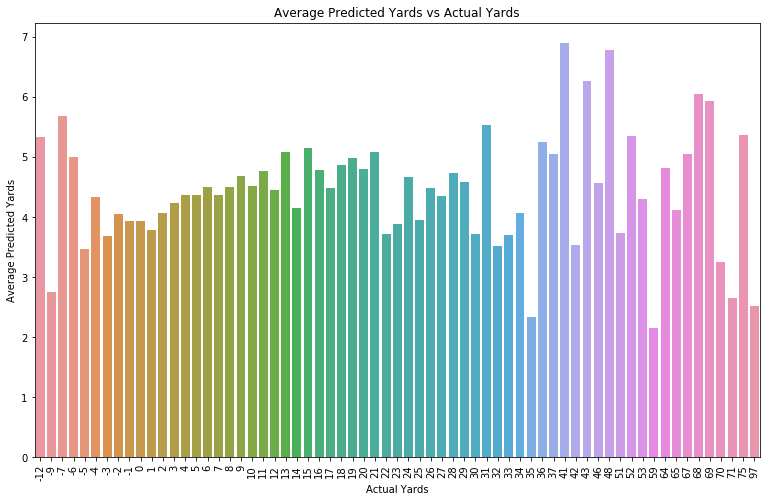

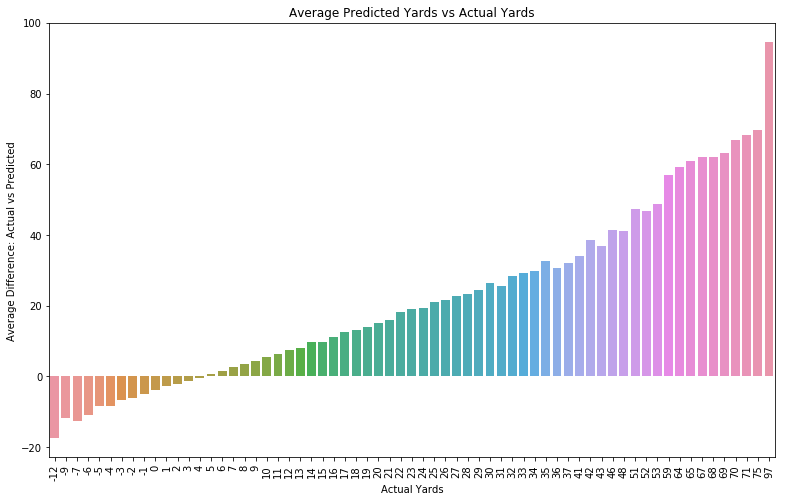

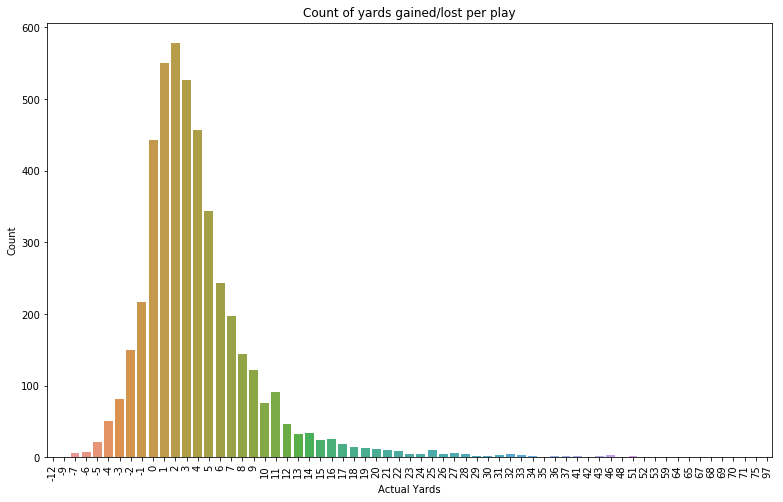

In [71]:
# Some additional visualizations for the model predictions against the actual values
linear_rmse_group = linear_rmse.groupby(by = 'Actual Yards').mean()
linear_rmse_group['Average difference'] = linear_rmse_group.index - linear_rmse_group['Predicted Yards']

x_linear = linear_rmse_group.index
y_linear = linear_rmse_group['Predicted Yards']
z_linear = linear_rmse_group['Average difference']

# Calculating the total number of records in the dataset for each individual number of yards gained/lost in a play -> this is stored in the variable 'exposures'
exposure_df = linear_rmse.groupby(by = 'Actual Yards').count()
exposure_df.rename(columns = {'Predicted Yards': 'Count'}, inplace = True)
exposures = exposure_df['Count']

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_linear, y_linear)
plt.xlabel('Actual Yards')
plt.ylabel('Average Predicted Yards')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_linear, z_linear)
plt.xlabel('Actual Yards')
plt.ylabel('Average Difference: Actual vs Predicted')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_linear, exposures)
plt.xlabel('Actual Yards')
plt.ylabel('Count')
plt.title('Count of yards gained/lost per play')
plt.xticks(rotation = 'vertical')
plt.show()

### XGBoost model

#### Untuned XGBoost model

In [40]:
# Building a transformer object from our trained model
xgb_transformer_untuned = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [41]:
# Running the batch tranform job
xgb_transformer_untuned.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer_untuned.wait()

........................[2019-12-12 15:12:19 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-12 15:12:19 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-12 15:12:19 +0000] [15] [INFO] Using worker: gevent
[2019-12-12 15:12:19 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-12 15:12:19 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-12 15:12:19 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-12 15:12:19 +0000] [25] [INFO] Booting worker with pid: 25
[2019-12-12:15:12:34:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [12/Dec/2019:15:12:34 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-12:15:12:34:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [12/Dec/2019:15:12:34 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-12:15:12:34:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [12/Dec/2019:15:12:34 +0000] "GET

In [42]:
# Using a bit of notebook magic to copy the output file from its S3 location and save it locally.
!aws s3 cp --recursive $xgb_transformer_untuned.output_path $data_dir

download: s3://sagemaker-us-east-2-961021140576/sagemaker-xgboost-2019-12-12-15-08-33-176/test.csv.out to ../data/test.csv.out


In [43]:
# Reading the predicted yardages from the XGBoost model's output
Y_pred_test_xgboost_untuned = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [44]:
print(min(np.array(Y_pred_test_xgboost_untuned)), max(np.array(Y_pred_test_xgboost_untuned)))

[-0.70404673] [11.80483818]


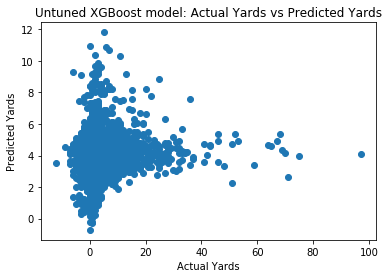

<Figure size 576x432 with 0 Axes>

In [45]:
# Plotting the predicted yardages against the actual yardages
plt.scatter(np.array(Y_test), np.array(Y_pred_test_xgboost_untuned))
plt.xlabel("Actual Yards")
plt.ylabel("Predicted Yards")
plt.title("Untuned XGBoost model: Actual Yards vs Predicted Yards")
plt.figure(figsize=(8,6))
plt.show()

In [48]:
# Creating a dataframe that will be passed to the 'rmse' function that calculates the RMSE for the models
# This dataframe simply contains two columns - one for the actual yards gained/lost in the the play, and another for the predicted yards gained/lost in the play
xgboost_rmse_untuned = Y_test
xgboost_rmse_untuned = xgboost_rmse_untuned.rename(columns = {'Yards': 'Actual Yards'})
xgboost_rmse_untuned['Predicted Yards'] = np.array(Y_pred_test_xgboost_untuned)

print(f"The RMSE for the untuned XGBoost model is {round(rmse(helpers.xgboost_rmse_untuned),2)}.")

The RMSE for the untuned XGBoost model is 6.36.


The untuned XGBoost model (with RMSE of 6.36) performs slightly better than the benchmark model (with RMSE of 6.43).

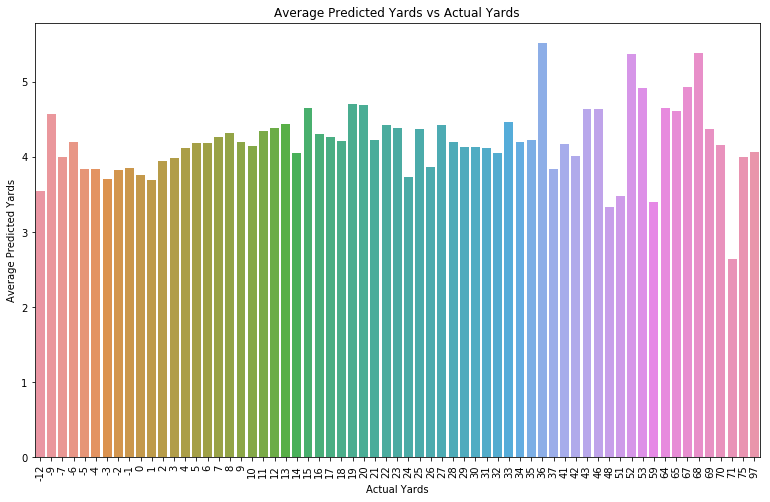

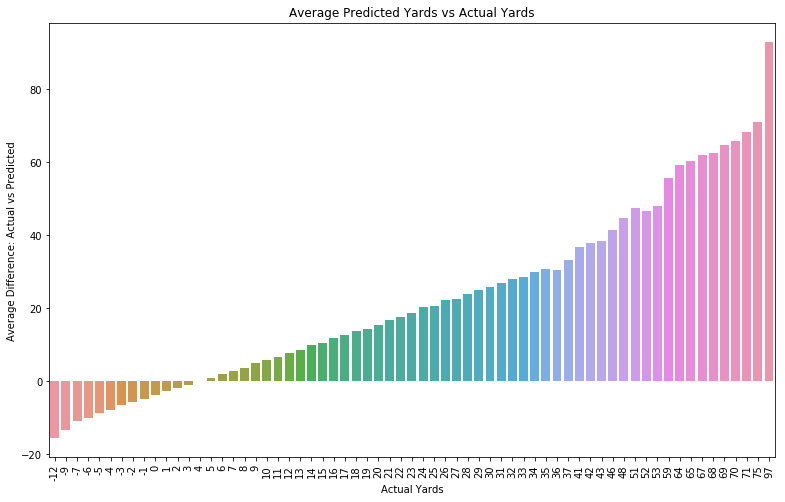

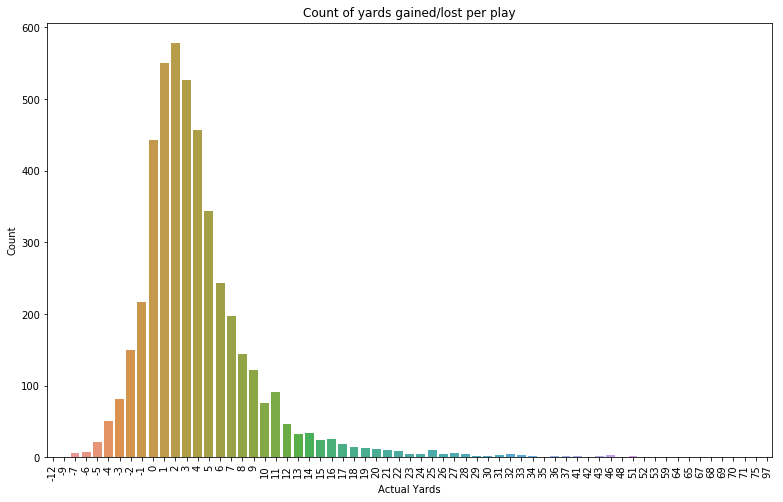

In [50]:
# Some additional visualizations for the model predictions against the actual values
xgboost_rmse_group = xgboost_rmse_untuned.groupby(by = 'Actual Yards').mean()
xgboost_rmse_group['Average difference'] = xgboost_rmse_group.index - xgboost_rmse_group['Predicted Yards']

x_xgb = xgboost_rmse_group.index
y_xgb = xgboost_rmse_group['Predicted Yards']
z_xgb = xgboost_rmse_group['Average difference']

# Calculating the total number of records in the dataset for each individual number of yards gained/lost in a play -> this is stored in the variable 'exposures'
exposure_df = xgboost_rmse_untuned.groupby(by = 'Actual Yards').count()
exposure_df.rename(columns = {'Predicted Yards': 'Count'}, inplace = True)
exposures = exposure_df['Count']

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, y_xgb)
plt.xlabel('Actual Yards')
plt.ylabel('Average Predicted Yards')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, z_xgb)
plt.xlabel('Actual Yards')
plt.ylabel('Average Difference: Actual vs Predicted')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, exposures)
plt.xlabel('Actual Yards')
plt.ylabel('Count')
plt.title('Count of yards gained/lost per play')
plt.xticks(rotation = 'vertical')
plt.show()

#### Tuned XGBoost model

From the above cells we observe that the untuned XGBoost model only slightly outperforms the benchmark model. We can try and improve on this model by using a hyperparameter-tuned version of the XGBoost model, i.e. the model with the set of hyperparameters that was selected with the specific goal of minimizing the RMSE. 

In [51]:
# Building a transformer object from our trained model
xgb_transformer_tuned = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [52]:
# Running the batch tranform job
xgb_transformer_tuned.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer_tuned.wait()

....................[2019-12-12 15:20:31 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2019-12-12 15:20:31 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2019-12-12 15:20:31 +0000] [15] [INFO] Using worker: gevent
[2019-12-12 15:20:31 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-12 15:20:32 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-12 15:20:32 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-12 15:20:32 +0000] [28] [INFO] Booting worker with pid: 28

[2019-12-12:15:20:48:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [12/Dec/2019:15:20:48 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2019-12-12:15:20:48:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [12/Dec/2019:15:20:48 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-12:15:20:48:INFO] No GPUs detected (normal if no gpus installed)
[2019-12-12:15:20:48:INFO] No GPUs detected (normal if n

In [53]:
# Using a bit of notebook magic to copy the output file from its S3 location and save it locally.
!aws s3 cp --recursive $xgb_transformer_tuned.output_path $data_dir

download: s3://sagemaker-us-east-2-961021140576/sagemaker-xgboost-191212-1443-019-91166-2019-12-12-15-17-22-496/test.csv.out to ../data/test.csv.out


In [54]:
# Reading the predicted yardages from the XGBoost model's output
Y_pred_test_xgboost_tuned = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [55]:
print(min(np.array(Y_pred_test_xgboost_tuned)), max(np.array(Y_pred_test_xgboost_tuned)))

[-0.2757802] [9.91730309]


From the above cell we see that the XGBoost model's predictions range from roughly -1 to 10. The variance in this model's predictions is less than that of the linear model we constructed earlier.

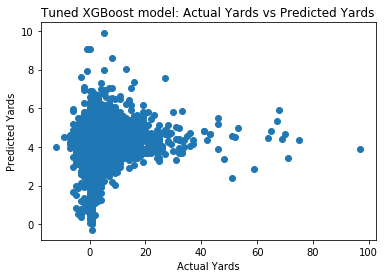

<Figure size 576x432 with 0 Axes>

In [56]:
# Plotting the predicted yardages against the actual yardages
plt.scatter(np.array(Y_test), np.array(Y_pred_test_xgboost_tuned))
plt.xlabel("Actual Yards")
plt.ylabel("Predicted Yards")
plt.title("Tuned XGBoost model: Actual Yards vs Predicted Yards")
plt.figure(figsize=(8,6))
plt.show()

In [57]:
# Creating a dataframe that will be passed to the 'rmse' function that calculates the RMSE for the models
# This dataframe simply contains two columns - one for the actual yards gained/lost in the the play, and another for the predicted yards gained/lost in the play
xgboost_rmse_tuned = Y_test
xgboost_rmse_tuned = xgboost_rmse_tuned.rename(columns = {'Yards': 'Actual Yards'})
xgboost_rmse_tuned['Predicted Yards'] = np.array(Y_pred_test_xgboost_tuned)

print(f"The RMSE for the tuned XGBoost model is {round(helpers.rmse(xgboost_rmse_tuned),2)}.")

The RMSE for the tuned XGBoost model is 6.34.


From the above output we see that the tuned XGBoost model (RMSE of 6.34) performs better than the linear regression model (RMSE of 6.43), as was the case with the untuned XGBoost model. Additionally, the tuned XGBoost model does even beter than the untuned version, albeit by a small margin (difference of 0.02 in RMSE). 

These results are a little surprising seeing that XGBoost is regarded as one of the best performing models out there at the moment. I was expecting both of these XGBoost models to do even better than they did. A possible reasons for this could be that the XGBoost models are still overfitting to the training data (albeit to a lesser extent than the linear regression model). To investigate this we could try reduce the number of features used in the training and predictions of the model and inspect the resultant performance. Another action we could take to improve the XGBoost model is restructuring the data. At this stage, the features can be divided into 3 sections: Those that relate to the play and game, those that relate to the offensive team and those that relate to the defensive team. This may, in hindsight, not be the most optimal way of utilising the data at our disposal. These aforementioned topics will not be discussed further in this notebook and could form part of an additional/subsequent investigation.

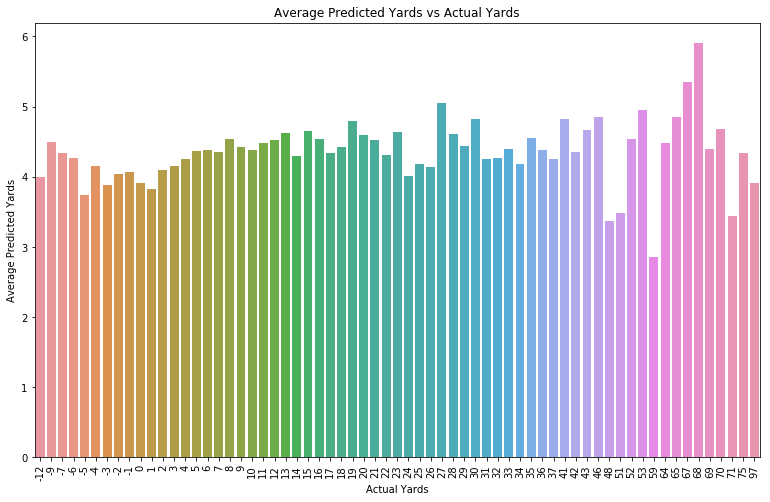

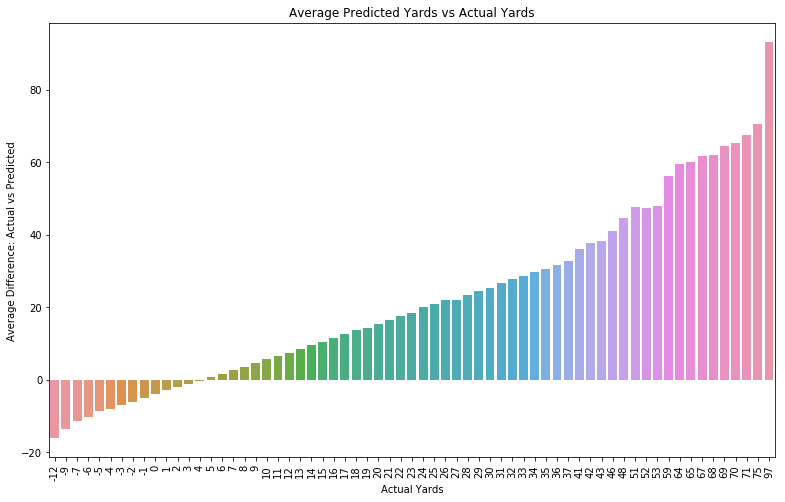

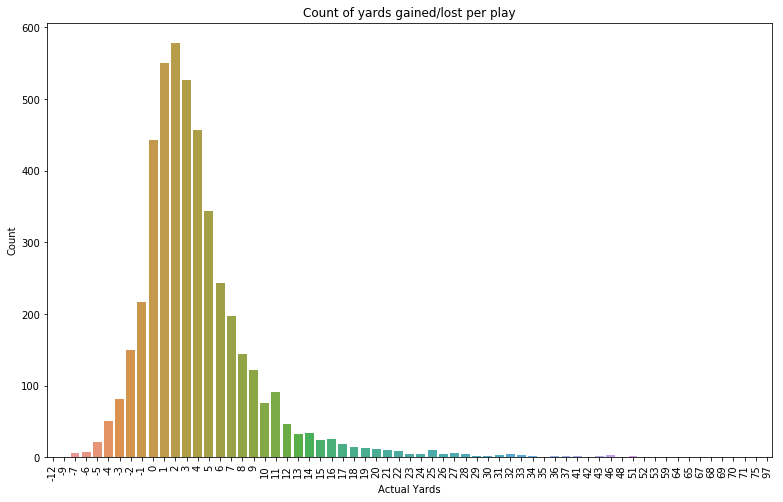

In [58]:
# Some additional visualizations for the model predictions against the actual values
xgboost_rmse_group = xgboost_rmse_tuned.groupby(by = 'Actual Yards').mean()
xgboost_rmse_group['Average difference'] = xgboost_rmse_group.index - xgboost_rmse_group['Predicted Yards']

x_xgb = xgboost_rmse_group.index
y_xgb = xgboost_rmse_group['Predicted Yards']
z_xgb = xgboost_rmse_group['Average difference']

# Calculating the total number of records in the dataset for each individual number of yards gained/lost in a play -> this is stored in the variable 'exposures'
exposure_df = xgboost_rmse_tuned.groupby(by = 'Actual Yards').count()
exposure_df.rename(columns = {'Predicted Yards': 'Count'}, inplace = True)
exposures = exposure_df['Count']

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, y_xgb)
plt.xlabel('Actual Yards')
plt.ylabel('Average Predicted Yards')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, z_xgb)
plt.xlabel('Actual Yards')
plt.ylabel('Average Difference: Actual vs Predicted')
plt.title('Average Predicted Yards vs Actual Yards')
plt.xticks(rotation = 'vertical')
plt.show()

# Plotting the average predicted yards against the actual yard groups
plt.figure(figsize = (13,8))
sns.barplot(x_xgb, exposures)
plt.xlabel('Actual Yards')
plt.ylabel('Count')
plt.title('Count of yards gained/lost per play')
plt.xticks(rotation = 'vertical')
plt.show()

In [72]:
# Calculating the average of the actual yards gained/lost in the test set. Also calculating the average of the predicted yards for both the linear regression model and XGBoost model
actual_ave_test = Y_test['Yards'].mean()
xgboost_ave_test = xgboost_rmse_group['Predicted Yards'].mean()
linear_ave_test = linear_rmse_group['Predicted Yards'].mean()

print(actual_ave_test, linear_ave_test, xgboost_ave_test)

4.146925566343042 4.44407062745309 4.356361582005876


From the first visualization above we can see that the tuned XGBoost model predicts plays to gain 4.44 yards on average. Very few plays are predicted to gain more than 5 yards. The main takeaway from the above images is that our XGBoost model does not perform well when the actual yards gained is very large. For example, the actual yards gained might have been 90, but the model predicted 4.5 yards to be gained. Our model has missed by quite a margin in this example. We need to keep in mind that most of the actual records saw plays gain between 0 - 6 yards (visible in the last graph above). If our model consistently predicts 4.44 yards to be gained, it does not miss the mark by too much for the majority of the observations.

In [80]:
# Last check to see what the RMSE would be if we use the average actual yardage (4.224035608308605) in the training set to predict on the test set
actual_ave_train = Y_train['Yards'].mean()
Y_test_X = Y_test.copy()
Y_test_X['Predicted using average'] = actual_ave_train

Y_test_X.rename(columns = {'Yards':'Actual Yards', 'Predicted using average':'Predicted Yards'}, inplace = True)

print(f"The RMSE for the Average model is {round(helpers.rmse(Y_test_X),2)}.")

The RMSE for the Average model is 6.41.


Using the actual average yardage in the training set to predict the observations in the test set produces an RMSE of 6.41, which is slightly better than the linear regression model's performance. At this stage, using the benchmark model is likely to produce less accurate yardage predictions than simply using the average of the past yards gained/lost. However, we notice that both of the XGBoost models (untuned and tuned) produce better results than the benchmark model and the average model. Whether this improvement is enough to justify the use of a more complex model that is more difficult to interpret (XGBoost) is another matter, which will not be discussed further in this notebook.

## 8. Clean-up

In [ ]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir

In [136]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))